In [1]:
import os
import numpy as np
import warnings

import tensorflow as tf
from tensorflow.python.tools.import_pb_to_tensorboard import import_to_tensorboard
from tensorflow.python.platform import gfile
from tensorflow.contrib.lite.python.lite import TFLiteConverter

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

In [2]:
label_dict = {
    0: 'NINE',
    1: 'ZERO',
    2: 'SEVEN',
    3: 'SIX',
    4: 'ONE',
    5: 'EIGHT',
    6: 'FOUR',
    7: 'THREE',
    8: 'TWO',
    9: 'FIVE', 
}

In [3]:
warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

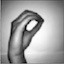

In [4]:
img = Image.open('test.jpg').convert('L')
display(img) # show the image

### Load PyTorch Model

In [5]:
# define the CNN architecture without Dropout layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1_1 = nn.Conv2d(1, 8, 3, padding=1)      
        self.conv1_2 = nn.Conv2d(8, 16, 3, padding=1)      
        self.conv1_3 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.pool1 = nn.MaxPool2d(2) 
        
        self.conv2_1 = nn.Conv2d(32, 40, 3, padding=1)      
        self.conv2_2 = nn.Conv2d(40, 48, 3, padding=1)      
        self.conv2_3 = nn.Conv2d(48, 64, 3, padding=1)

        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3_1 = nn.Conv2d(64, 72, 3, padding=1)      
        self.conv3_2 = nn.Conv2d(72, 80, 3, padding=1)      
        self.conv3_3 = nn.Conv2d(80, 96, 3, padding=1)
        
        self.pool3 = nn.MaxPool2d(2)
        
        self.conv4_1 = nn.Conv2d(96, 128, 3, padding=1)      
        self.conv4_2 = nn.Conv2d(128, 192, 3, padding=1)
        self.conv4_3 = nn.Conv2d(192, 256, 3, padding=1)
        
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        # 64x64x1 => 32x32x8
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))
        x = F.relu(self.pool1(x))
        
        # 32x32x8 => 16x16x16
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))
        x = F.relu(self.pool2(x))
        
        # 16x16x16 => 8x8x32
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.relu(self.pool3(x))
        
        # 8x8x32 => 8x8x256
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))

        # Reduce Mean & Linear
        x = torch.mean(torch.mean(x, dim=-1), dim=-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [6]:
# Load model
model = Net()
model.load_state_dict(torch.load('./model_sl_3968.pt', map_location=lambda storage, location: storage))
model.eval()

Net(
  (conv1_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(32, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(40, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_3): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(64, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(72, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(80, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(96, 128, 

In [7]:
# Test predict
x = torch.from_numpy(np.expand_dims(np.expand_dims(np.asarray(img, dtype=np.float32), axis=0), axis=0))
y = model(x)

y_idx = torch.argmax(y)
y, label_dict[int(y_idx)]

(tensor([[ -3.2384,  32.9433,  -6.1564, -18.4737,  -2.4728,   0.2746,  -1.5060,
          -14.4440, -26.7159,  -7.6219]], grad_fn=<ThAddmmBackward>), 'ZERO')

In [8]:
model.conv1_1.weight.shape, model.conv1_1.weight.permute([0, 2, 3, 1]).shape

(torch.Size([8, 1, 3, 3]), torch.Size([8, 3, 3, 1]))

### Import to Tensorflow

In [9]:
def add_prediction_op(x, torch_model):    
#     # 64x64x1 => 32x32x8
#     x = F.relu(self.conv1_1(x))
#     x = F.relu(self.conv1_2(x))
#     x = F.relu(self.conv1_3(x))
#     x = F.relu(self.pool1(x))

#     self.conv1_1 = nn.Conv2d(1, 8, 3, padding=1)      
#     self.conv1_2 = nn.Conv2d(8, 16, 3, padding=1)      
#     self.conv1_3 = nn.Conv2d(16, 24, 3, padding=1)
#     self.pool1 = nn.Conv2d(24, 32, 3, padding=1, stride=2) 
        
    # 64x64x1 => 32x32x8
    x = tf.layers.conv2d(x, 8, 3, padding='same', activation=tf.nn.relu, name='conv1_1', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv1_1.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv1_1.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 16, 3, padding='same', activation=tf.nn.relu, name='conv1_2', trainable=False, 
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv1_2.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv1_2.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 32, 3, padding='same', activation=tf.nn.relu, name='conv1_3', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv1_3.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv1_3.bias.detach().numpy())
    )
    x = tf.layers.max_pooling2d(x, 2, 2, name='pool1')
    
#     # 32x32x8 => 16x16x16
#     x = F.relu(self.conv2_1(x))
#     x = F.relu(self.conv2_2(x))
#     x = F.relu(self.conv2_3(x))
#     x = F.relu(self.pool2(x))

#     self.conv2_1 = nn.Conv2d(32, 40, 3, padding=1)      
#     self.conv2_2 = nn.Conv2d(40, 48, 3, padding=1)      
#     self.conv2_3 = nn.Conv2d(48, 56, 3, padding=1)
#     self.pool2 = nn.Conv2d(56, 64, 3, padding=1, stride=2)

    # 32x32x8 => 16x16x16
    x = tf.layers.conv2d(x, 40, 3, padding='same', activation=tf.nn.relu, name='conv2_1', trainable=False, 
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv2_1.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv2_1.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 48, 3, padding='same', activation=tf.nn.relu, name='conv2_2', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv2_2.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv2_2.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 64, 3, padding='same', activation=tf.nn.relu, name='conv2_3', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv2_3.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv2_3.bias.detach().numpy())
    )
    x = tf.layers.max_pooling2d(x, 2, 2, name='pool2')

#     # 16x16x16 => 8x8x32
#     x = F.relu(self.conv3_1(x))
#     x = F.relu(self.conv3_2(x))
#     x = F.relu(self.conv3_3(x))
#     x = F.relu(self.pool3(x))

#     self.conv3_1 = nn.Conv2d(64, 72, 3, padding=1)      
#     self.conv3_2 = nn.Conv2d(72, 80, 3, padding=1)      
#     self.conv3_3 = nn.Conv2d(80, 88, 3, padding=1)
#     self.pool3 = nn.Conv2d(88, 96, 3, padding=1, stride=2)

    # 16x16x16 => 8x8x32
    x = tf.layers.conv2d(x, 72, 3, padding='same', activation=tf.nn.relu, name='conv3_1', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv3_1.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv3_1.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 80, 3, padding='same', activation=tf.nn.relu, name='conv3_2', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv3_2.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv3_2.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 96, 3, padding='same', activation=tf.nn.relu, name='conv3_3', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv3_3.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv3_3.bias.detach().numpy())
    )
    x = tf.layers.max_pooling2d(x, 2, 2, name='pool3')

#     # 8x8x32 => 8x8x256
#     x = F.relu(self.conv4_1(x))
#     x = F.relu(self.conv4_2(x))
#     x = F.relu(self.conv4_3(x))

#     self.conv4_1 = nn.Conv2d(96, 128, 3, padding=1)      
#     self.conv4_2 = nn.Conv2d(128, 192, 3, padding=1)
#     self.conv4_3 = nn.Conv2d(192, 256, 3, padding=1)

    # 8x8x32 => 8x8x256
    x = tf.layers.conv2d(x, 128, 3, padding='same', activation=tf.nn.relu, name='conv4_1', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv4_1.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv4_1.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 192, 3, padding='same', activation=tf.nn.relu, name='conv4_2', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv4_2.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv4_2.bias.detach().numpy())
    )
    x = tf.layers.conv2d(x, 256, 3, padding='same', activation=tf.nn.relu, name='conv4_3', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv4_3.weight.permute([2, 3, 1, 0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.conv4_3.bias.detach().numpy())
    )

#     x = torch.mean(torch.mean(x, dim=-1), dim=-1)
#     x = F.relu(self.fc1(x))
#     x = self.fc2(x)

#     self.fc1 = nn.Linear(256, 1024)
#     self.fc2 = nn.Linear(1024, 10)    

    # Reduce Mean & Linear
    x = tf.math.reduce_mean(tf.math.reduce_mean(x, axis=2), axis=1)
    x = tf.layers.dense(x, 1024, name='fc1', activation=tf.nn.relu, trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.fc1.weight.permute([1,0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.fc1.bias.detach().numpy())
    )
    y = tf.layers.dense(x, 10, name='fc2', trainable=False,
            kernel_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.fc2.weight.permute([1,0]).detach().numpy()),
            bias_initializer=lambda x, dtype, partition_info: tf.constant(torch_model.fc2.bias.detach().numpy())
    )

    return y

In [10]:
# Reset Graph
tf.reset_default_graph()

# Generate Model
input_placeholder = tf.placeholder(tf.float32, shape=(None, 64, 64, 1), name="0")
pred_tensor = tf.identity(add_prediction_op(input_placeholder, model), name="pred")

# Compare With PyTorch Result

In [11]:
vals = [] 

tx = x.clone()
tx = F.relu(model.conv1_1(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv1_2(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv1_3(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.pool1(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())

# 32x32x8 => 16x16x16
tx = F.relu(model.conv2_1(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv2_2(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv2_3(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.pool2(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())

# 16x16x16 => 8x8x32
tx = F.relu(model.conv3_1(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv3_2(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv3_3(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.pool3(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())

# 8x8x32 => 8x8x256
tx = F.relu(model.conv4_1(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv4_2(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())
tx = F.relu(model.conv4_3(tx))
vals.append(tx.permute(0,2,3,1).detach().numpy())

# Reduce Mean & Linear
tx = torch.mean(torch.mean(tx, dim=-1), dim=-1)
vals.append(tx.permute(1,0).detach().numpy())
tx = F.relu(model.fc1(tx))
vals.append(tx.permute(1,0).detach().numpy())
tx = model.fc2(tx)
vals.append(tx.permute(1,0).detach().numpy())

In [12]:
y_idx = np.argmax(vals[17])
np.transpose(vals[17]),label_dict[int(y_idx)]

(array([[ -3.2383766 ,  32.943295  ,  -6.1564054 , -18.473711  ,
          -2.472799  ,   0.27463526,  -1.5059702 , -14.443997  ,
         -26.71591   ,  -7.621882  ]], dtype=float32), 'ZERO')

In [13]:
tf_x = x.permute([0,2,3,1]).detach().double().numpy()
with tf.Session() as sess: 
    init = tf.global_variables_initializer()
    sess.run(init)
    
    y0 = sess.run('pred:0', feed_dict={'0:0':tf_x})
    y1 = sess.run(pred_tensor, feed_dict={input_placeholder:tf_x})

In [14]:
y0_idx = np.argmax(y0)
y0, label_dict[int(y0_idx)]

(array([[ -3.2383754 ,  32.943283  ,  -6.156398  , -18.473707  ,
          -2.4727986 ,   0.27463734,  -1.5059701 , -14.443996  ,
         -26.715906  ,  -7.621884  ]], dtype=float32), 'ZERO')

In [15]:
y1_idx = np.argmax(y1)
y1, label_dict[int(y1_idx)]

(array([[ -3.2383754 ,  32.943283  ,  -6.156398  , -18.473707  ,
          -2.4727986 ,   0.27463734,  -1.5059701 , -14.443996  ,
         -26.715906  ,  -7.621884  ]], dtype=float32), 'ZERO')

In [16]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    output_nodes_name = [
        'conv1_1/kernel','conv1_1/bias','conv1_2/kernel','conv1_2/bias','conv1_3/kernel','conv1_3/bias',
        'conv2_1/kernel','conv2_1/bias','conv2_2/kernel','conv2_2/bias','conv2_3/kernel','conv2_3/bias',
        'conv3_1/kernel','conv3_1/bias','conv3_2/kernel','conv3_2/bias','conv3_3/kernel','conv3_3/bias',
        'conv4_1/kernel','conv4_1/bias','conv4_2/kernel','conv4_2/bias','conv4_3/kernel','conv4_3/bias',
        'fc1/kernel','fc1/bias','fc2/kernel','fc2/bias','pred'
    ]
    
    output_graph_def = tf.graph_util.convert_variables_to_constants(
        sess, # The session is used to retrieve the weights
        tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
        output_nodes_name # The output node names are used to select the usefull nodes
    ) 
    
    file = open('sign_lang_net.pb', "wb")
    file.write(output_graph_def.SerializeToString())
    file.close()

INFO:tensorflow:Froze 28 variables.
INFO:tensorflow:Converted 28 variables to const ops.


In [17]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['0',
 'conv1_1/kernel/Initializer/Const',
 'conv1_1/kernel',
 'conv1_1/kernel/Assign',
 'conv1_1/kernel/read',
 'conv1_1/bias/Initializer/Const',
 'conv1_1/bias',
 'conv1_1/bias/Assign',
 'conv1_1/bias/read',
 'conv1_1/dilation_rate',
 'conv1_1/Conv2D',
 'conv1_1/BiasAdd',
 'conv1_1/Relu',
 'conv1_2/kernel/Initializer/Const',
 'conv1_2/kernel',
 'conv1_2/kernel/Assign',
 'conv1_2/kernel/read',
 'conv1_2/bias/Initializer/Const',
 'conv1_2/bias',
 'conv1_2/bias/Assign',
 'conv1_2/bias/read',
 'conv1_2/dilation_rate',
 'conv1_2/Conv2D',
 'conv1_2/BiasAdd',
 'conv1_2/Relu',
 'conv1_3/kernel/Initializer/Const',
 'conv1_3/kernel',
 'conv1_3/kernel/Assign',
 'conv1_3/kernel/read',
 'conv1_3/bias/Initializer/Const',
 'conv1_3/bias',
 'conv1_3/bias/Assign',
 'conv1_3/bias/read',
 'conv1_3/dilation_rate',
 'conv1_3/Conv2D',
 'conv1_3/BiasAdd',
 'conv1_3/Relu',
 'pool1/MaxPool',
 'conv2_1/kernel/Initializer/Const',
 'conv2_1/kernel',
 'conv2_1/kernel/Assign',
 'conv2_1/kernel/read',
 'conv2_1/bi

### Load Tensorflow Graph

In [18]:
in_tensor = 'import/0:0'
out_tensor = 'import/pred:0'

In [19]:
tf.reset_default_graph()
with gfile.FastGFile("sign_lang_net.pb", 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

    with tf.Session() as sess:
        tf.import_graph_def(graph_def)
        sess.graph.as_default()
        
        sess.run(tf.global_variables_initializer())
        
        feed_dict = dict([(in_tensor, x.permute([0,2,3,1]))])
        y = sess.run(out_tensor, feed_dict=feed_dict)
        
        print(y, label_dict[np.argmax(y)])

Instructions for updating:
Use tf.gfile.GFile.
[[ -3.2383754   32.943283    -6.156398   -18.473707    -2.4727986
    0.27463734  -1.5059701  -14.443996   -26.715906    -7.621884  ]] ZERO


# Move to Tensoflow Lite Model

In [20]:
in_tensor = '0'
out_tensor = 'pred'

In [21]:
graph_def_file = "sign_lang_net.pb"
input_arrays = [in_tensor]
output_arrays = [out_tensor]

converter = TFLiteConverter.from_frozen_graph(graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()

open("sign_lang_net.tflite", "wb").write(tflite_model)

5098924